In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
asda
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 필요 라이브러리 Import 
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split 

In [ ]:
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']   # 평가 정보 데이터 컬럼명 설정 

dog_ratings = pd.read_csv('/content/drive/MyDrive/LAMDA/pet_data/recom_dataset/dog_data_kfold.csv')
dog_ratings = dog_ratings[['m_no', 'goodsno', 'point']].astype(int)

In [ ]:
dog_item = pd.read_csv('/content/drive/MyDrive/LAMDA/pet_data/recom_dataset/dog_item.csv')
dog_item.set_index('goodsno', inplace=True)

In [ ]:
rating_matrix = dog_ratings.pivot(index='m_no', columns='goodsno', values='point')

In [ ]:
X = dog_ratings.copy()

X.columns

Index(['m_no', 'goodsno', 'point'], dtype='object')

In [ ]:
from sklearn.model_selection import StratifiedKFold 

def split_df(df, kfold_n=5):
    '''
    df col: img_path, label
    '''
    kfold = StratifiedKFold(n_splits=kfold_n)
    
    # 클래스 비율 고려하여 Fold 별로 데이터 분리 
    X = np.array(df) 
    y = df.m_no.values 
    
    datas = [] 
    for i, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        train_df = df.iloc[train_idx].copy().reset_index(drop=True)
        test_df = df.iloc[val_idx].copy().reset_index(drop=True) 
        
        datas.append((train_df, test_df))
    return datas

datas = split_df(X)

In [ ]:
def RMSE(y_true, y_pred):
  '''
  RMSE 함수 정의 
  '''
  return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [ ]:
import tensorflow as tf 
from tensorflow.keras import layers 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.optimizers import SGD, Adamax 

In [ ]:
# variable 초기화
K = 200   # Latent factor (잠재요인) 수 
mu = datas[4][0].point.mean()   # 전체 평균  
# M = len(dog_ratings['m_no'].unique()) + 1   # 사용자 아이디의 최대값을 구함 (embedding에 사용)
# N = len(dog_ratings['goodsno'].unique()) + 1   # 영화 아이디의 최대값을 구함 (embedding에 사용) 
M = dog_ratings.m_no.max() + 1 
N = dog_ratings.goodsno.max() + 1 

In [ ]:
# model0
user = Input(shape=(1, ))   # 사용자 데이터 입력 형식 지정 
item = Input(shape=(1, ))   # 아이템 데이터 입력 형식 지정 
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)   # 사용자 embedding layer 
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)   # 아이템 embedding layer 
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)   # 사용자 bias embedding layer 
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)   # 아이템 bias embedding layer 

R = layers.dot([P_embedding, Q_embedding], axes=2)   # 사용자, 아이템 embedding 레이어를 내적 연산 (dot product). axes를 통해 축을 설정함
R = layers.add([R, user_bias, item_bias])   # 사용자 bias, 아이템 bias를 더함 
R = Flatten()(R)   # 차원 압축 (1차원 배열 형태로 변환)

model0 = Model(inputs=[user, item], outputs=R)   # 입력과 출력 정의 
model0.compile(loss=RMSE, optimizer=SGD(), metrics=[RMSE])   # 모델 컴파일 
model0.summary()   # 모델 구조 요약 

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 200)       189043600   ['input_3[0][0]']                
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 200)       17546800    ['input_4[0][0]']                
                                                                                            

In [ ]:
num_fold = 5 

results = [] 
for fold in range(0, num_fold):
  x = datas[fold][0] 
  y = datas[fold][0]['m_no']
  x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y)
  
  result = model0.fit(
    x = [x_train.m_no.values, x_train.goodsno.values],   # train set의 입력 지정 
    y = x_train.point.values - mu,   # train set의 출력 지정 
    epochs = 100,   # 반복 횟수 지정 
    batch_size=512,   # 한 번에 학습하는 batch size 지정 
    validation_data = (   # 정확도 측정을 위한 validation set 지정 
        [x_val.m_no.values, x_val.goodsno.values],   
        x_val.point.values - mu
    )
  )
    
  results.append(result)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:439: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 189043600 elements. This may consume a large amount of memory.
  num_elements)


125/125 [==============================] - 9s 42ms/step - loss: 1688.9419 - RMSE: 0.8823 - val_loss: 1646.7676 - val_RMSE: 0.8936
Epoch 2/100
125/125 [==============================] - 5s 39ms/step - loss: 1606.6056 - RMSE: 0.8820 - val_loss: 1566.4893 - val_RMSE: 0.8932
Epoch 3/100
125/125 [==============================] - 5s 39ms/step - loss: 1528.2854 - RMSE: 0.8813 - val_loss: 1490.1262 - val_RMSE: 0.8928
Epoch 4/100
125/125 [==============================] - 5s 39ms/step - loss: 1453.7866 - RMSE: 0.8814 - val_loss: 1417.4878 - val_RMSE: 0.8925
Epoch 5/100
125/125 [==============================] - 5s 39ms/step - loss: 1382.9191 - RMSE: 0.8809 - val_loss: 1348.3925 - val_RMSE: 0.8921
Epoch 6/100
125/125 [==============================] - 5s 39ms/step - loss: 1315.5093 - RMSE: 0.8803 - val_loss: 1282.6671 - val_RMSE: 0.8917
Epoch 7/100
125/125 [==============================] - 5s 39ms/step - loss: 1251.3875 - RMSE: 0.8799 - val_loss: 1220.1477 - val_RMSE: 0.8914
Epoch 8/100
125/12

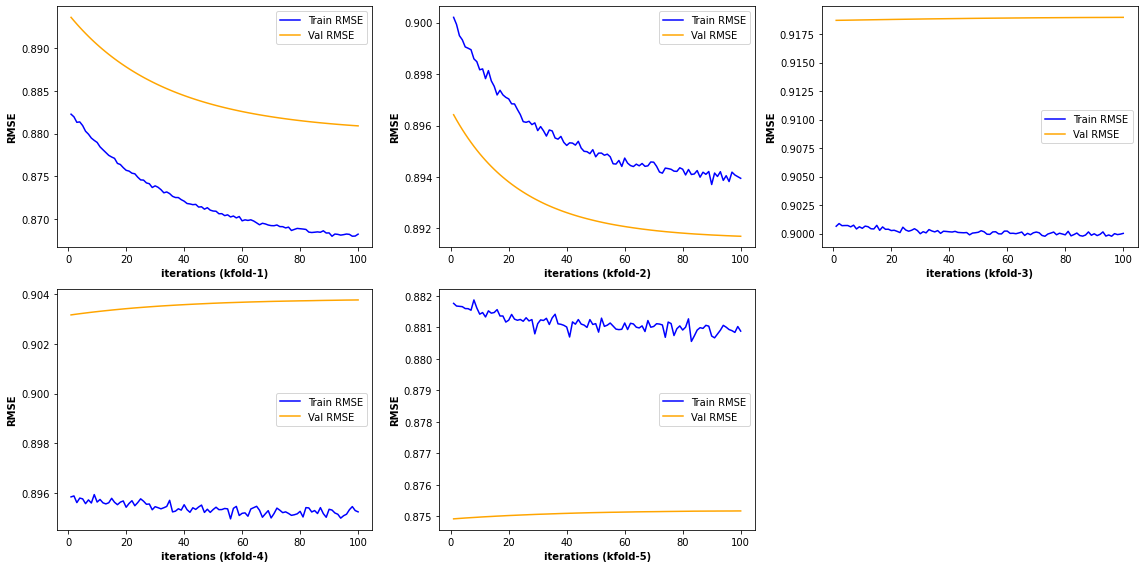

In [ ]:
import matplotlib.pyplot as plt 

f, ax = plt.subplots(2, 3, figsize=(16, 8))
labels = ['kfold-1', 'kfold-2', 'kfold-3', 'kfold-4', 'kfold-5']
idx = 0 

for i in range(2):    
  for j in range(3):   
    try:
      ax[i, j].plot([x for x in range(1, 101)], results[idx].history['RMSE'], color='blue', label = 'Train RMSE')
      ax[i, j].plot([x for x in range(1, 101)], results[idx].history['val_RMSE'], color='orange', label = 'Val RMSE')
      # ax[i, j].set_ylim(0.5, 1.5)   # y축 범위 설정하기 
      ax[i, j].set_xlabel(f'iterations ({labels[idx]})', fontweight='bold')   
      ax[i, j].set_ylabel('RMSE', fontweight='bold')
      idx += 1
      ax[i, j].legend()
    except IndexError:
       ax[i, j].set_visible(False)

f.tight_layout()
plt.show()

In [ ]:
 # Keras Model
user = Input(shape=(1, ))   # 사용자 데이터 입력 형식 지정 
item = Input(shape=(1, ))   # 아이템 데이터 입력 형식 지정 
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)   # 사용자 embedding layer 
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)   # 아이템 embedding layer 
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)   # 사용자 bias embedding layer 
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)   # 아이템 bias embedding layer 
                       
# Concatenate layers 
from tensorflow.keras.layers import Dense, Concatenate, Activation 

# Concatenate를 수행하기 위해, 각각의 레이어들을 1차원으로 변환함 
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)
R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias])

# Neural network
R = Dense(2048)(R)   # 노드가 2,048개인 Dense Layer 추가 
R = Activation('relu')(R)   # 활성화 함수로 linear 사용 
R = Dense(256)(R)   # 노드가 256개인 Dense Layer 추가 
R = Activation('linear')(R)   # 활성화 함수로 linear 사용 
R = Dense(1)(R)   # 노드가 1개인 출력 Dense Layer 추가 

In [ ]:
# model 생성 
model1 = Model(inputs=[user, item], outputs=R)
model1.compile(   
    loss = RMSE,   # loss 함수로 앞서 정의한 RMSE 사용 
    optimizer = SGD(),   # optimizer: SGD
    metrics=[RMSE]   # 측정지표: RMSE
)

model1.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_13 (Embedding)       (None, 1, 200)       189043600   ['input_8[0][0]']                
                                                                                                  
 embedding_14 (Embedding)       (None, 1, 200)       17546800    ['input_9[0][0]']                
                                                                                            

In [ ]:
num_fold = 5 

results1 = [] 
for fold in range(0, num_fold):
  x = datas[fold][0] 
  y = datas[fold][0]['m_no']
  x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y)
  
  result1 = model1.fit(
    x = [x_train.m_no.values, x_train.goodsno.values],   # train set의 입력 지정 
    y = x_train.point.values - mu,   # train set의 출력 지정 
    epochs = 100,   # 반복 횟수 지정 
    batch_size=512,   # 한 번에 학습하는 batch size 지정 
    validation_data = (   # 정확도 측정을 위한 validation set 지정 
        [x_val.m_no.values, x_val.goodsno.values],   
        x_val.point.values - mu
    )
  )
    
  results1.append(result1)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:439: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 189043600 elements. This may consume a large amount of memory.
  num_elements)


125/125 [==============================] - 7s 42ms/step - loss: 1689.0305 - RMSE: 0.8855 - val_loss: 1646.8318 - val_RMSE: 0.8720
Epoch 2/100
125/125 [==============================] - 5s 40ms/step - loss: 1606.6903 - RMSE: 0.8850 - val_loss: 1566.5493 - val_RMSE: 0.8716
Epoch 3/100
125/125 [==============================] - 5s 40ms/step - loss: 1528.3666 - RMSE: 0.8849 - val_loss: 1490.1825 - val_RMSE: 0.8713
Epoch 4/100
125/125 [==============================] - 5s 40ms/step - loss: 1453.8625 - RMSE: 0.8845 - val_loss: 1417.5410 - val_RMSE: 0.8710
Epoch 5/100
125/125 [==============================] - 5s 40ms/step - loss: 1382.9926 - RMSE: 0.8841 - val_loss: 1348.4421 - val_RMSE: 0.8707
Epoch 6/100
125/125 [==============================] - 5s 40ms/step - loss: 1315.5796 - RMSE: 0.8838 - val_loss: 1282.7137 - val_RMSE: 0.8705
Epoch 7/100
125/125 [==============================] - 5s 40ms/step - loss: 1251.4546 - RMSE: 0.8834 - val_loss: 1220.1910 - val_RMSE: 0.8702
Epoch 8/100
125/12

https://dbstndi6316.tistory.com/275  - kfold

In [ ]:
results1[0].history['RMSE']

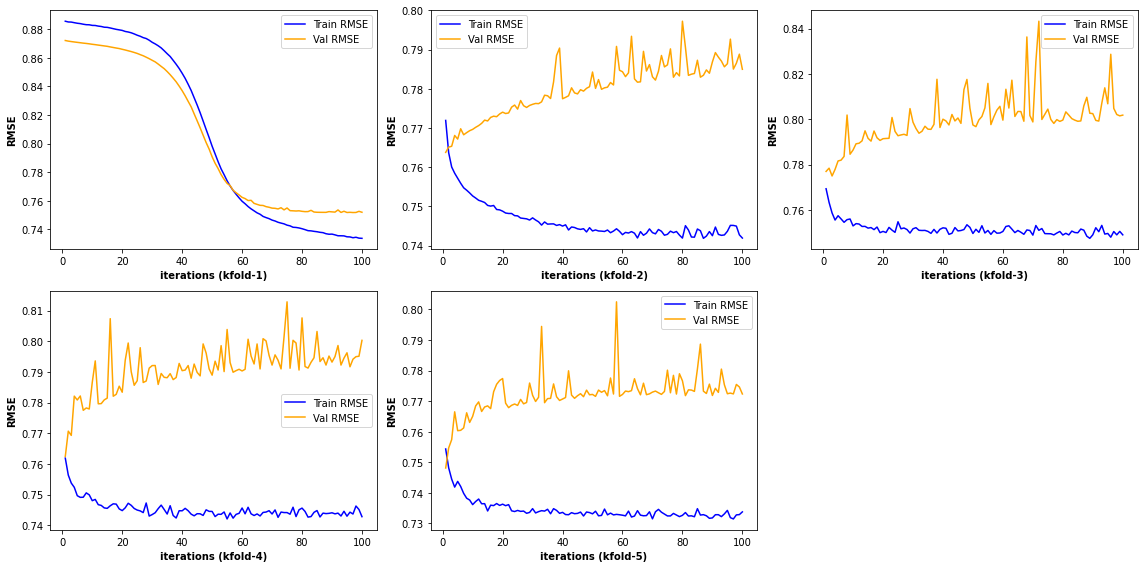

In [ ]:
import matplotlib.pyplot as plt 

f, ax = plt.subplots(2, 3, figsize=(16, 8))
labels = ['kfold-1', 'kfold-2', 'kfold-3', 'kfold-4', 'kfold-5']
idx = 0 

for i in range(2):    
  for j in range(3):   
    try:
      ax[i, j].plot([x for x in range(1, 101)], results1[idx].history['RMSE'], color='blue', label = 'Train RMSE')
      ax[i, j].plot([x for x in range(1, 101)], results1[idx].history['val_RMSE'], color='orange', label = 'Val RMSE')
      # ax[i, j].set_ylim(0.5, 1.5)   # y축 범위 설정하기 
      ax[i, j].set_xlabel(f'iterations ({labels[idx]})', fontweight='bold')   
      ax[i, j].set_ylabel('RMSE', fontweight='bold')
      idx += 1
      ax[i, j].legend()
    except IndexError:
       ax[i, j].set_visible(False)

f.tight_layout()
plt.show()

In [ ]:
users = pd.read_csv('/content/drive/MyDrive/LAMDA/pet_data/recom_dataset/dog_user.csv')
users = users[['m_no', 'dogname']]  # 사용자 데이터를 읽어와서 ID와 성별(sex)만 남김 

p_type = {}
def convert_type(x):
  '''
  현재 string으로 되어 있는 성별을 int로 바꾸는 함수 
  '''
  if x in p_type:   # 현재의 sex에 대응하는 int값이 dictionary에 존재하면 
    return p_type[x]   # 해당 값 반환   
  else:   # 그렇지 않으면 
    p_type[x] = len(p_type)   # 새로운 element를 새로운 int값과 같이 dictionary에 추가 
    return p_type[x]   #새로운 int값 반환 

users['dogname'] = users['dogname'].apply(convert_type)   # 사용자 데이터의 'sex' 컬럼을 int로 변환 

L = len(p_type)   # 성별의 unique value의 개수를 저장함 (embedding 하는데 사용)

In [ ]:
L

174

In [ ]:
# Keras Model
user2 = Input(shape=(1, ))   # 사용자 데이터 입력 형식 지정 
item2 = Input(shape=(1, ))   # 아이템 데이터 입력 형식 지정
p_type = Input(shape=(1, ))   # 성별 데이터 입력 형식 지정 
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user2)   # 사용자 embedding layer 
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item2)   # 아이템 embedding layer
type_embedding = Embedding(L, 3, embeddings_regularizer=l2())(p_type)  # 반려동물 embedding layer 
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user2)   # 사용자 bias embedding layer 
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item2)   # 아이템 bias embedding layer 

from tensorflow.keras.layers import Dense, Concatenate, Activation 

# Concatenate를 수행하기 위해, 각각의 레이어들을 1차원으로 변환함 
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)
type_layer = Flatten()(type_embedding)

R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, type_layer])

# Neural network
R = Dense(2048)(R)   # 노드가 2,048개인 Dense Layer 추가 
R = Activation('relu')(R)   # 활성화 함수로 linear 사용 
R = Dense(256)(R)   # 노드가 256개인 Dense Layer 추가 
R = Activation('linear')(R)   # 활성화 함수로 linear 사용 
R = Dense(1)(R)   # 노드가 1개인 출력 Dense Layer 추가 

In [ ]:
# model 생성 
model2 = Model(inputs=[user2, item2, p_type], outputs=R)
model2.compile(   
    loss = RMSE,   # loss 함수로 앞서 정의한 RMSE 사용 
    optimizer = SGD(),   # optimizer: SGD
    metrics=[RMSE]   # 측정지표: RMSE
)

model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 1, 200)       189043600   ['input_5[0][0]']                
                                                                                            

In [ ]:
num_fold = 5   # kfold 수  

results2 = [] 
for fold in range(0, num_fold):
  x = datas[fold][0]
  y = datas[fold][0]['m_no']
  x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y)
  
  train_type = pd.merge(x_train, users, on='m_no')['dogname']   # train set과 사용자 데이터 병합  
  val_type = pd.merge(x_val, users, on='m_no')['dogname']   # test set과 사용자 데이터 병합 

  result2 = model2.fit(
    x = [x_train.m_no.values, x_train.goodsno.values, train_type.values],   # train set의 입력 지정 
    y = x_train.point.values - mu,   # train set의 출력 지정 
    epochs = 100,   # 반복 횟수 지정 
    batch_size=512,   # 한 번에 학습하는 batch size 지정 
    validation_data = (   # 정확도 측정을 위한 validation set 지정 
        [x_val.m_no.values, x_val.goodsno.values, val_type.values],   
        x_val.point.values - mu
    )
  )
    
  results2.append(result2)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:439: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 189043600 elements. This may consume a large amount of memory.
  num_elements)


125/125 [==============================] - 7s 42ms/step - loss: 1688.8937 - RMSE: 0.8811 - val_loss: 1646.7222 - val_RMSE: 0.8910
Epoch 2/100
125/125 [==============================] - 5s 40ms/step - loss: 1606.5602 - RMSE: 0.8806 - val_loss: 1566.4457 - val_RMSE: 0.8907
Epoch 3/100
125/125 [==============================] - 5s 40ms/step - loss: 1528.2418 - RMSE: 0.8802 - val_loss: 1490.0850 - val_RMSE: 0.8903
Epoch 4/100
125/125 [==============================] - 5s 41ms/step - loss: 1453.7443 - RMSE: 0.8798 - val_loss: 1417.4489 - val_RMSE: 0.8901
Epoch 5/100
125/125 [==============================] - 5s 41ms/step - loss: 1382.8802 - RMSE: 0.8796 - val_loss: 1348.3551 - val_RMSE: 0.8898
Epoch 6/100
125/125 [==============================] - 5s 40ms/step - loss: 1315.4724 - RMSE: 0.8794 - val_loss: 1282.6322 - val_RMSE: 0.8896
Epoch 7/100
125/125 [==============================] - 5s 40ms/step - loss: 1251.3523 - RMSE: 0.8791 - val_loss: 1220.1144 - val_RMSE: 0.8893
Epoch 8/100
125/12

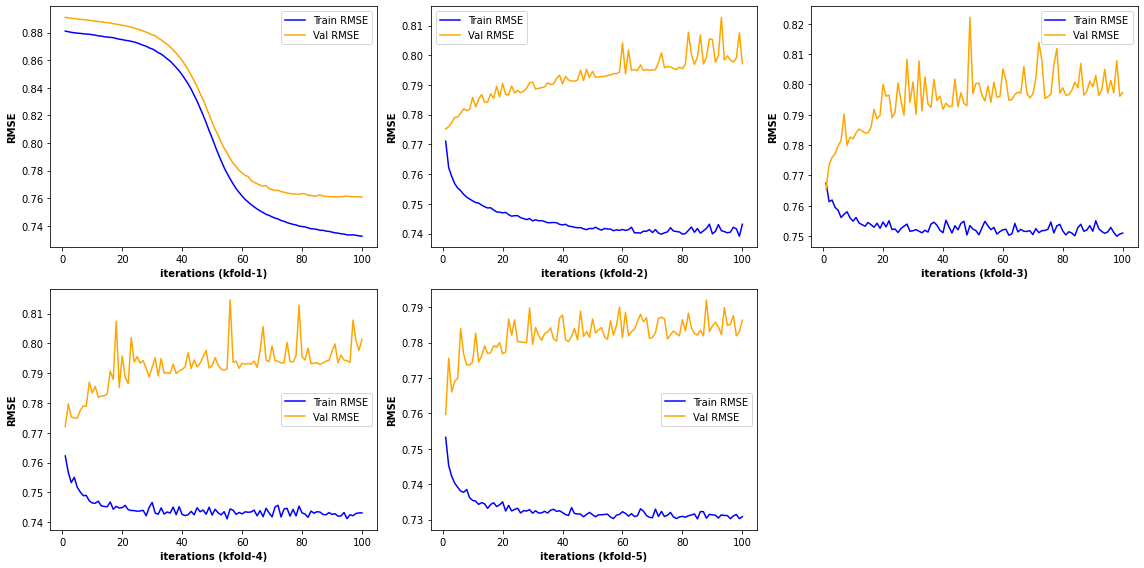

In [ ]:
import matplotlib.pyplot as plt 

f, ax = plt.subplots(2, 3, figsize=(16, 8))
labels = ['kfold-1', 'kfold-2', 'kfold-3', 'kfold-4', 'kfold-5']
idx = 0 

for i in range(2):    
  for j in range(3):   
    try:
      ax[i, j].plot([x for x in range(1, 101)], results2[idx].history['RMSE'], color='blue', label = 'Train RMSE')
      ax[i, j].plot([x for x in range(1, 101)], results2[idx].history['val_RMSE'], color='orange', label = 'Val RMSE')
      # ax[i, j].set_ylim(0.5, 1.5)   # y축 범위 설정하기 
      ax[i, j].set_xlabel(f'iterations ({labels[idx]})', fontweight='bold')   
      ax[i, j].set_ylabel('RMSE', fontweight='bold')
      idx += 1
      ax[i, j].legend()
    except IndexError:
       ax[i, j].set_visible(False)

f.tight_layout()
plt.show()

In [ ]:
def convert_sent(point_list):
  list_p = []
  for idx, point in enumerate(point_list):
    if point < 3:
      list_p.append(0)
    else:
      list_p.append(1)
  print(len(list_p))
  return list_p

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

def c_matrix(model): 
  ''' 
  score 함수 수정: 모델 이름 + neighbor_size 지정할 수 있도록 파라미터 변경 
  model 입력으로 받아, test 데이터에 대한 RMSE 값을 계산하여 반환 
  '''
  id_pairs = zip(datas[4][1]['m_no'], datas[4][1]['goodsno'])    # id_pairs: (user_id1, goodsno1), (user_id2, goodsno2), (user_id3, goodsno3) 쌍을 얻음 
  y_pred = np.array([model.predict([np.array([user, ]),np.array([item, ])]) + mu for (user, item) in id_pairs])   # user_id와 movie_id 값을 이용해 예측 값 계산 
  # print(y_pred, type(y_pred))
  y_pred = list(convert_sent(list(y_pred)))
  y_true = list(convert_sent(datas[4][1]['point']))   # test 데이터의 실제 값 저장 
  
  # print(len(y_pred), len(y_true), type(y_pred), type(y_true))
  cm = confusion_matrix(y_true, y_pred)
  cmdf = pd.DataFrame(cm, index=['실제값(1)', '실제값(0)'], columns=['예측값(1)', '예측값(0)'])
  return cmdf

In [ ]:
mu

4.4422

In [ ]:
c_matrix(model)

20000
20000


,예측값(1),예측값(0)
실제값(1),54,957
실제값(0),189,18800


In [ ]:
def recom_items(user_id, n_items):   # 4분 
  user_item = rating_matrix.loc[user_id].copy()
  for item in rating_matrix:
    if pd.notnull(user_item.loc[item]):
      user_item.loc[item] = 0
    else:   # model.predict([np.array([user_id, ]),np.array([item, ])]) + mu
      # 푸들 = 0 
      # user_item.loc[item] = model2.predict([np.array([user_id, ]),np.array([item, ]), np.array([0, ])]) + mu
      user_item.loc[item] = model.predict([np.array([user_id, ]),np.array([item, ])]) + mu

  item_sort = user_item.sort_values(ascending=False)[:n_items]
  recom_items = dog_item.loc[item_sort.index]
  recommendations = recom_items['goodsnm']
  return recommendations 

recom_items(98380, 5)

goodsno
61102         반려생활 건강한 간식 체력 80g
19251      쥬크 힙액션 피넛버터 관절강화 170g
6709      리얼스토리 숯불 슬라이스 사사미 300g
6849     오렌지하우스 스위트키스 어포사사미 400g
43004          복슬강아지 치즈무지개떡 200g
Name: goodsnm, dtype: object

In [ ]:
# datas[4][1]

test_type = pd.merge(datas[4][1], users, on='m_no')['dogname']

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

def c_matrix(model2): 
  ''' 
  score 함수 수정: 모델 이름 + neighbor_size 지정할 수 있도록 파라미터 변경 
  model 입력으로 받아, test 데이터에 대한 RMSE 값을 계산하여 반환 
  '''
  id_pairs = zip(datas[4][1]['m_no'], datas[4][1]['goodsno'], test_type.values)    # id_pairs: (user_id1, goodsno1), (user_id2, goodsno2), (user_id3, goodsno3) 쌍을 얻음 
  y_pred = np.array([model2.predict([np.array([user, ]),np.array([item, ]), np.array([dogtype, ])]) + mu for (user, item, dogtype) in id_pairs])   # user_id와 movie_id 값을 이용해 예측 값 계산 
  # print(y_pred, type(y_pred))
  y_pred = list(convert_sent(list(y_pred)))
  y_true = list(convert_sent(datas[4][1]['point']))   # test 데이터의 실제 값 저장 
  
  # print(len(y_pred), len(y_true), type(y_pred), type(y_true))
  cm = confusion_matrix(y_true, y_pred)
  cmdf = psd.DataFrame(cm, index=['실제값(1)', '실제값(0)'], columns=['예측값(1)', '예측값(0)'])
  return cmdf

In [ ]:
c_matrix(model2)

20000
20000


,예측값(1),예측값(0)
실제값(1),63,948
실제값(0),160,18829


In [ ]:
# Keras Model
user3 = Input(shape=(1, ))   # 사용자 데이터 입력 형식 지정 
item3 = Input(shape=(1, ))   # 아이템 데이터 입력 형식 지정
p_type = Input(shape=(1, ))   # 성별 데이터 입력 형식 지정 
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user3)   # 사용자 embedding layer 
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item3)   # 아이템 embedding layer
type_embedding = Embedding(L, 3, embeddings_regularizer=l2())(p_type)  # 반려동물 embedding layer 
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user3)   # 사용자 bias embedding layer 
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item3)   # 아이템 bias embedding layer 

from tensorflow.keras.layers import Dense, Concatenate, Activation 

# Concatenate를 수행하기 위해, 각각의 레이어들을 1차원으로 변환함 
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)
type_layer = Flatten()(type_embedding)

R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, type_layer])

# Neural network
R = Dense(2048)(R)   # 노드가 2,048개인 Dense Layer 추가 
R = Activation('relu')(R)   # 활성화 함수로 linear 사용 
R = Dense(256)(R)   # 노드가 256개인 Dense Layer 추가 
R = Activation('linear')(R)   # 활성화 함수로 linear 사용 
R = Dense(1)(R)   # 노드가 1개인 출력 Dense Layer 추가 

In [ ]:
# model 생성 
model3 = Model(inputs=[user3, item3, p_type], outputs=R)
model3.compile(   
    loss = RMSE,   # loss 함수로 앞서 정의한 RMSE 사용 
    optimizer = SGD(),   # optimizer: SGD
    metrics=[RMSE]   # 측정지표: RMSE
)

# model2.summary()

In [ ]:
num_fold = 5   # kfold 수  

results3 = [] 
for fold in range(0, num_fold):
  x = datas[fold][0]
  y = datas[fold][0]['m_no']
  x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y)
  
  train_type = pd.merge(x_train, users, on='m_no')['dogname']   # train set과 사용자 데이터 병합  
  val_type = pd.merge(x_val, users, on='m_no')['dogname']   # test set과 사용자 데이터 병합 

  result2 = model3.fit(
    x = [x_train.m_no.values, x_train.goodsno.values, train_type.values],   # train set의 입력 지정 
    y = x_train.point.values - mu,   # train set의 출력 지정 
    epochs = 500,   # 반복 횟수 지정 
    batch_size=512,   # 한 번에 학습하는 batch size 지정 
    validation_data = (   # 정확도 측정을 위한 validation set 지정 
        [x_val.m_no.values, x_val.goodsno.values, val_type.values],   
        x_val.point.values - mu
    )
  )
    
  results3.append(result2)